In [1]:
# !pip install selenium beautifulsoup4
# !pip install google-play-scraper
# !pip install seaborn
!pip uninstall -y konlpy jpype1
!pip install jpype1==1.4.1
!pip install konlpy==0.6.0
# !pip install tqdm
# !pip install plotly

##### 커널 재시작해야 반영됨 Jupyter: Kernel > Restart
# !pip install --upgrade pillow
# !pip install --upgrade wordcloud

Found existing installation: konlpy 0.6.0
Uninstalling konlpy-0.6.0:
  Successfully uninstalled konlpy-0.6.0
Found existing installation: jpype1 1.6.0
Uninstalling jpype1-1.6.0:
  Successfully uninstalled jpype1-1.6.0
  Using cached JPype1-1.4.1-cp39-cp39-win_amd64.whl.metadata (4.9 kB)
Using cached JPype1-1.4.1-cp39-cp39-win_amd64.whl (345 kB)



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached konlpy-0.6.0-py2.py3-none-any.whl.metadata (1.9 kB)
Using cached konlpy-0.6.0-py2.py3-none-any.whl (19.4 MB)



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
#######################################
##### 1. 플레이스토어 리뷰 크롤링 #####
#######################################

from google_play_scraper import reviews, Sort
import pandas as pd
import datetime
import time

# 라프텔 앱 ID
app_id = 'laftel.net.laftel'

# 수집 기준 날짜 설정
# AVOD 서비스 기간: 2018-11-01 ~ 2025-06-29
avod_start_date = datetime.datetime(2018, 11, 1)
avod_end_date = datetime.datetime(2025, 6, 30, 0, 0, 0)

# 최대 수집 리뷰 수: 3천 개로 제한
max_reviews = 3000
all_reviews = []
next_token = None

# 크롤링 시작
while len(all_reviews) < max_reviews:
    new_reviews, next_token = reviews(
        app_id,
        lang='ko',         # 한국어 리뷰만
        country='kr',      # 한국
        sort=Sort.NEWEST,  # 최신순 정렬
        count=100,
        continuation_token=next_token
    )
    all_reviews.extend(new_reviews)
    # print(f"수집된 리뷰 수: {len(all_reviews)}")  # for debug
    
    if not next_token:
        break
    time.sleep(1)  # 서버 과부하 방지

# 데이터프레임으로 변환
origin_df = pd.DataFrame(all_reviews)

# 전체 리뷰 수 확인
print("✅ 크롤링 완료")
print(f"전체 리뷰 수: {len(origin_df)}")

✅ 크롤링 완료
전체 리뷰 수: 3000


In [2]:
origin_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,251f408a-6062-4d2e-84f7-7254256a9161,하누,https://play-lh.googleusercontent.com/a/ACg8oc...,첨엔 광고만보면 볼수있었는데 지금은 가입해야해서 볼만한게 없고 미션을께야지 볼수있어...,3,0,3.68.0,2025-07-26 16:58:49,None,NaT,3.68.0
1,596eb8c1-174d-4e66-b082-5bef248a24b3,ᄋᄋᄋᄋ,https://play-lh.googleusercontent.com/a/ACg8oc...,호들요 꼭보셈,5,0,3.68.0,2025-07-26 14:07:07,None,NaT,3.68.0
2,03479d2b-cc58-47ea-9a53-1f9885745e16,신소연,https://play-lh.googleusercontent.com/a/ACg8oc...,애니 몇몇개 못봄. 깔지 마셈 차라리 티빙을 사라,1,0,None,2025-07-26 13:39:05,None,NaT,None
3,37157115-a128-4a92-8adf-b796345c4742,김종분,https://play-lh.googleusercontent.com/a-/ALV-U...,평생쓸듯 ㄹㅇ루,5,0,3.68.0,2025-07-26 13:03:15,None,NaT,3.68.0
4,e4b5c33d-04d1-4f26-b634-f591c9922b9f,정원도,https://play-lh.googleusercontent.com/a/ACg8oc...,소녀종말여해 추가해줘여ㅕㅕ,5,0,3.68.0,2025-07-26 07:46:54,None,NaT,3.68.0


In [3]:
##### 데이터프레임 열 정리 #####

# 날짜 형식 및 AVOD 시작일 이전 리뷰 삭제 등 전처리
own_df = origin_df.copy()
own_df['date'] = pd.to_datetime(own_df['at'])  # 열 이름 변경: at > date
own_df = own_df[own_df['date'] >= avod_start_date]

# 분석에 필요한 열만 남기기
# userName, content, score, thumbsUpCount, reviewCreatedVersion, date, replyContent, appVersion
own_df = own_df.drop(['userImage', 'repliedAt', 'at'], axis=1)

# AVOD 종료 전/후 구분 열 생성
own_df['avod_end'] = own_df['date'].apply(lambda x: 'before' if x < avod_end_date else 'after')

# csv 파일로 저장
own_df.to_csv('laftel_playstore_reviews_all.csv', index=False, encoding='utf-8-sig')

# AVOD 종료 이전/이후 리뷰 수 확인
own_df['avod_end'].value_counts()

avod_end
before    2909
after       91
Name: count, dtype: int64

In [4]:
print(own_df.columns)  # 전체 열 확인

Index(['reviewId', 'userName', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'replyContent', 'appVersion', 'date',
       'avod_end'],
      dtype='object')


In [5]:
own_df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,replyContent,appVersion,date,avod_end
0,251f408a-6062-4d2e-84f7-7254256a9161,하누,첨엔 광고만보면 볼수있었는데 지금은 가입해야해서 볼만한게 없고 미션을께야지 볼수있어...,3,0,3.68.0,None,3.68.0,2025-07-26 16:58:49,after
1,596eb8c1-174d-4e66-b082-5bef248a24b3,ᄋᄋᄋᄋ,호들요 꼭보셈,5,0,3.68.0,None,3.68.0,2025-07-26 14:07:07,after
2,03479d2b-cc58-47ea-9a53-1f9885745e16,신소연,애니 몇몇개 못봄. 깔지 마셈 차라리 티빙을 사라,1,0,None,None,None,2025-07-26 13:39:05,after
3,37157115-a128-4a92-8adf-b796345c4742,김종분,평생쓸듯 ㄹㅇ루,5,0,3.68.0,None,3.68.0,2025-07-26 13:03:15,after
4,e4b5c33d-04d1-4f26-b634-f591c9922b9f,정원도,소녀종말여해 추가해줘여ㅕㅕ,5,0,3.68.0,None,3.68.0,2025-07-26 07:46:54,after


In [6]:
print(own_df['avod_end'].unique())

['after' 'before']


In [7]:
##### 그래프 그리기 전 최초 1회 실행 #####
##### 글자 깨짐 방지용 #####

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 한글 폰트 설정
mpl.rcParams['font.family'] = 'Malgun Gothic'  # Windows OS

# 마이너스 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

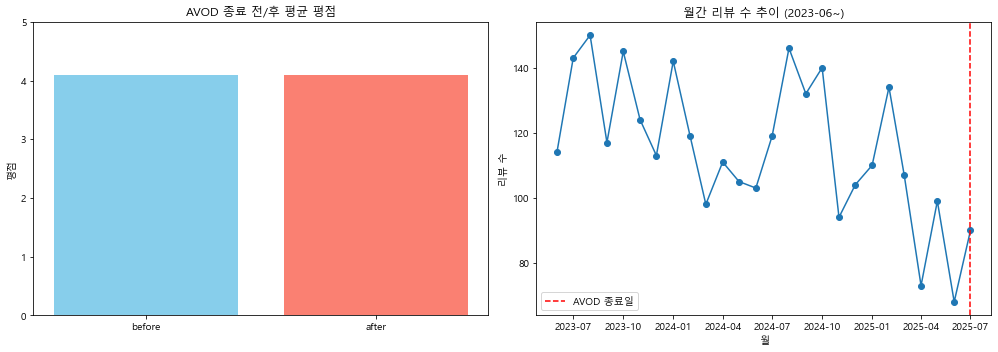

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# AVOD 서비스 종료일
avod_end_date = pd.Timestamp('2025-06-30')

# --- 1. AVOD 종료 전/후 평균 평점 ---
avg_rating = own_df.groupby('avod_end')['score'].mean()

# --- 2. 월간 리뷰 수 추이 ---
monthly_df = own_df.copy()
monthly_df['month'] = monthly_df['date'].dt.to_period('M')  # 월간 구분 열 생성
monthly_reviews = monthly_df.groupby('month').size().reset_index(name='리뷰 수')
monthly_reviews['month'] = monthly_reviews['month'].dt.to_timestamp()

# --- 시각화 ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
desired_order = ['before', 'after']
avg_rating = avg_rating.reindex(desired_order)  # 레이블 순서 재배치

# (1) 평균 평점 막대그래프
axes[0].bar(avg_rating.index, avg_rating.values, color=['skyblue', 'salmon'])
axes[0].set_title('AVOD 종료 전/후 평균 평점')
axes[0].set_ylim(0, 5)
axes[0].set_ylabel('평점')

# (2) 월간 리뷰 수 선그래프
axes[1].plot(monthly_reviews['month'], monthly_reviews['리뷰 수'], marker='o')
axes[1].axvline(avod_end_date, color='red', linestyle='--', label='AVOD 종료일')
axes[1].set_title('월간 리뷰 수 추이 (2023-06~)')
axes[1].set_ylabel('리뷰 수')
axes[1].set_xlabel('월')
axes[1].legend()

plt.tight_layout()
plt.show()

In [10]:
# ===============================================================================
# 1. 텍스트 전처리
# - 리뷰 텍스트를 분석 가능한 형태로 정제
# ===============================================================================

In [11]:
import pandas as pd
import re
from konlpy.tag import Okt

okt = Okt()

# 한국어 불용어 리스트 (*파일 경로 확인)
with open('stopwords-ko.txt', 'r', encoding='utf-8') as f:
    data = f.read().splitlines()
stopwords_df = pd.DataFrame(data, columns=['text'])
external_stopwords = stopwords_df['text'].tolist()

# 불용어 내부 정의
own_stopwords = ['라서', '건가', '줫으', '엇으', '이나', '지나', '아아', '여서', '거임', '너무', '하면', '하고', '하는', '있습니다', '없습니다', '없음', '있음', '있는', '없는', '있으면', '없으면', '있어서', '없어서', '마다', '통해', '때문', '제일', '매우', '더욱', '살짝', '보고', '보면', '보임', '해도', '적도', '항상', '경우', '진짜', '정말', '그냥', '고도', '입니다']

# 불용어 리스트 통합
combined_stopwords = set(external_stopwords + own_stopwords)

def preprocess_text_kor(text):
    text = re.sub(r"[^가-힣a-zA-Z\s]", "", str(text).lower())    # 특수문자 제거
    tokens = okt.morphs(text)                                    # 형태소 단위로 나누기
    tokens = [t for t in tokens if t not in combined_stopwords and len(t) > 1]  # 불용어 제거 + 한 글자 제거
    return " ".join(tokens)

own_df['okt_content'] = own_df['content'].apply(preprocess_text_kor)

In [12]:
own_df['okt_content']

0       광고 볼수있었는데 지금 가입 해야 해서 없고 미션 볼수있어서 힘들어요 근데 가보고십...
1                                                      보셈
2                                       애니 몇몇 깔지 마셈 티빙 사라
3                                                   평생 쓸듯
4                                         소녀 종말 여해 추가 해줘여
                              ...                        
2995                                                 좋습니다
2996                                    재밌게 보고있어요 별개 드림니다
2997          결제 애니 보다가 갑자기 끊으면 짜랍니까 한참 재밌게 있었는데 결제 영상 하아
2998    애니메이션 좋아하면 넷플 보다 잘쓸수있어요 근데 생각 보다 판권 내려가는 애니 많아...
2999                    여러 애니 볼수있어 좋아요 광고 지주 뜨고 괴도 조커 없나용
Name: okt_content, Length: 3000, dtype: object

In [13]:
# ===============================================================================
# 2. AVOD 종료 전/후 키워드 비교
# - AVOD 종료 전/후 사용자 주요 관심사 변화 파악
# - TF-IDF 기반 키워드 비교 + 워드클라우드
# ===============================================================================

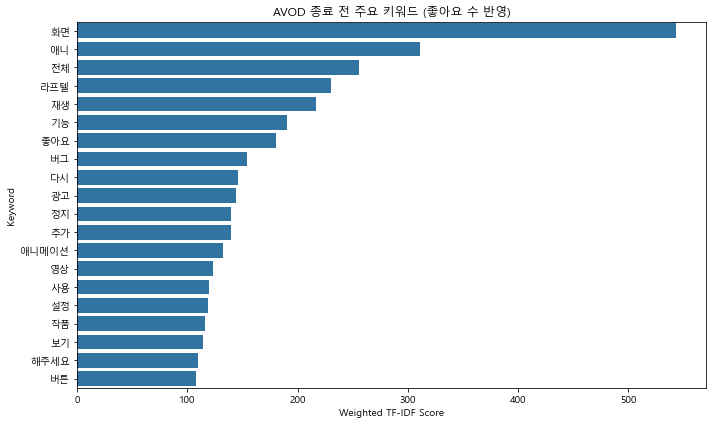

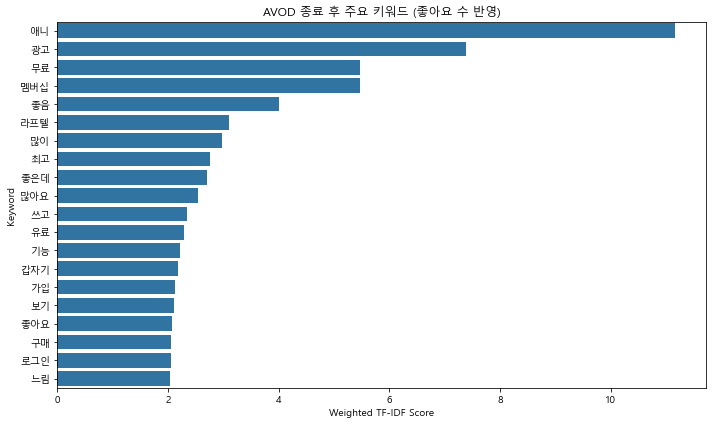

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# AVOD 종료 전/후 데이터
before_df = own_df[own_df['avod_end'] == 'before'].copy()
after_df = own_df[own_df['avod_end'] == 'after'].copy()

# NaN이나 이상치(-1 등)가 있을 수 있으니 thumbsUpCount 전처리 (null > 0)
before_df['thumbsUpCount'] = before_df['thumbsUpCount'].fillna(0)
after_df['thumbsUpCount'] = after_df['thumbsUpCount'].fillna(0)

# TF-IDF 벡터화 함수 (가중치 포함)
def get_top_weighted_tfidf_words(docs, weights, top_n=20):
    vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1,1))
    tfidf_matrix = vectorizer.fit_transform(docs)

    # 가중치 shape 맞추기
    weight_array = np.array(weights).reshape(-1, 1)

    # TF-IDF × (좋아요 수 + 1)
    weighted_tfidf = tfidf_matrix.multiply(weight_array)
    weighted_scores = weighted_tfidf.sum(axis=0).A1

    tfidf_df = pd.DataFrame({
        'term': vectorizer.get_feature_names_out(),
        'score': weighted_scores
    })
    return tfidf_df.sort_values(by='score', ascending=False).head(top_n)

# 가중치 계산을 위한 전처리: thumbsUpCount + 1(리뷰 작성자)
weights_before = before_df['thumbsUpCount'] + 1
weights_after = after_df['thumbsUpCount'] + 1

# 주요 키워드 추출 (가중치 반영)
top_words_before = get_top_weighted_tfidf_words(before_df['okt_content'], weights_before)
top_words_after = get_top_weighted_tfidf_words(after_df['okt_content'], weights_after)

# 시각화
def plot_keywords(df, title):
    plt.figure(figsize=(10,6))
    sns.barplot(x='score', y='term', data=df)
    plt.title(title)
    plt.xlabel("Weighted TF-IDF Score")
    plt.ylabel("Keyword")
    plt.tight_layout()
    plt.show()

plot_keywords(top_words_before, "AVOD 종료 전 주요 키워드 (좋아요 수 반영)")
plot_keywords(top_words_after, "AVOD 종료 후 주요 키워드 (좋아요 수 반영)")

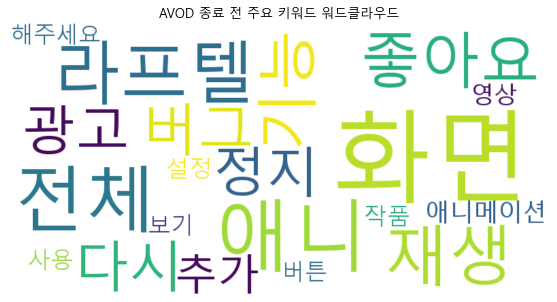

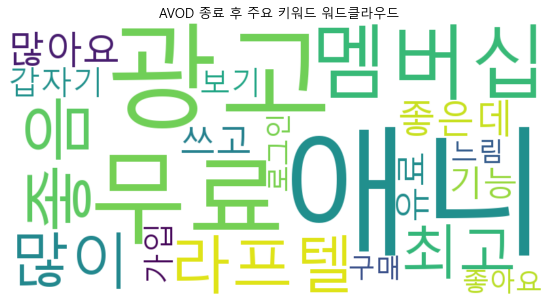

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 워드클라우드 생성 함수
def plot_weighted_wordcloud(df, title):
    word_freq = dict(zip(df['term'], df['score']))  # Keyword 크기: 가중 TF-IDF 점수에 비례
    wordcloud = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf',  # Windows OS
                          background_color='white',
                          width=800, height=400).generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=13)
    plt.axis("off")
    plt.show()

# 시각화
plot_weighted_wordcloud(top_words_before, "AVOD 종료 전 주요 키워드 워드클라우드")
plot_weighted_wordcloud(top_words_after, "AVOD 종료 후 주요 키워드 워드클라우드")

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

# TF-IDF 버블 데이터 생성 함수
def get_tfidf_bubble_data(docs, weights=None):
    vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1,1))
    tfidf_matrix = vectorizer.fit_transform(docs)
    feature_names = vectorizer.get_feature_names_out()
    
    if weights is not None:
        weight_array = np.array(weights).reshape(-1, 1)
        tfidf_matrix = tfidf_matrix.multiply(weight_array)

    tfidf_array = tfidf_matrix.toarray()

    term_data = []
    for i, term in enumerate(feature_names):
        term_tfidf_values = tfidf_array[:, i]
        term_docs = term_tfidf_values > 0
        doc_count = term_docs.sum()
        total_score = term_tfidf_values.sum()
        if doc_count > 0:
            mean_score = total_score / doc_count
        else:
            mean_score = 0
        term_data.append({
            'term': term,
            'doc_count': doc_count,
            'mean_tfidf': mean_score,
            'total_tfidf': total_score
        })

    return pd.DataFrame(term_data).sort_values(by='total_tfidf', ascending=False)

In [17]:
import plotly.express as px

# Plotly 버블 차트 생성 함수
def plot_bubble_chart(df, title):
    fig = px.scatter(
        df,
        x='mean_tfidf',
        y='doc_count',
        size='total_tfidf',
        text='term',
        hover_data=['term', 'mean_tfidf', 'doc_count', 'total_tfidf'],
        title=title,
        size_max=60
    )
    fig.update_traces(textposition='top center')
    fig.update_layout(
        xaxis_title="평균 TF-IDF 점수",
        yaxis_title="리뷰 등장 문서 수",
        template='plotly_white'
    )
    fig.show()

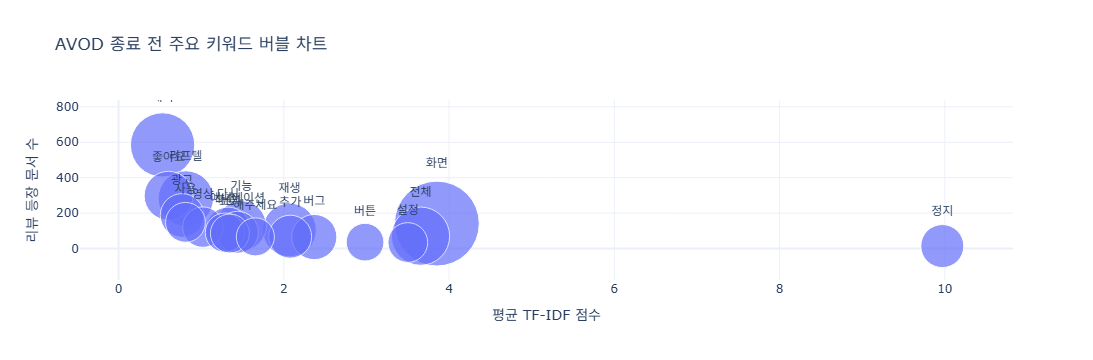

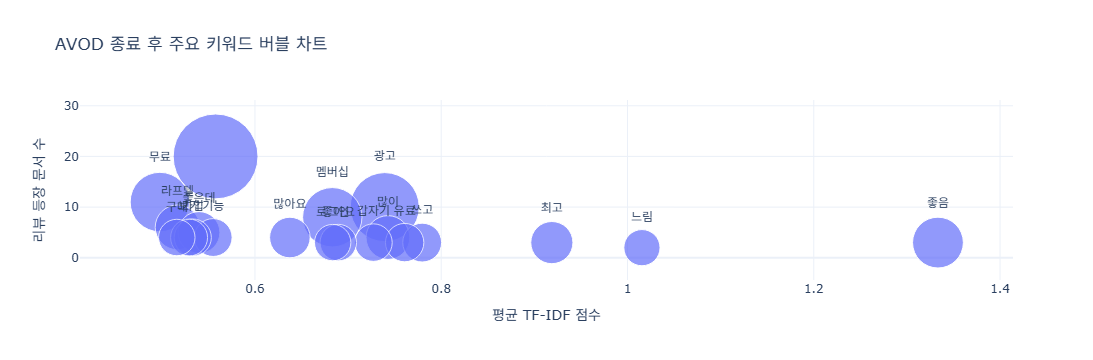

In [18]:
# TF-IDF 버블 데이터 생성
bubble_before = get_tfidf_bubble_data(before_df['okt_content'], weights_before)
bubble_after = get_tfidf_bubble_data(after_df['okt_content'], weights_after)

# 버블 차트 출력 (총 TF-IDF 점수가 높은 상위 20개 키워드)
plot_bubble_chart(bubble_before.head(20), "AVOD 종료 전 주요 키워드 버블 차트")
plot_bubble_chart(bubble_after.head(20), "AVOD 종료 후 주요 키워드 버블 차트")

In [19]:
# ===============================================================================
# 3. 감성 분석 (긍정/부정 비율)
# - 종료 전/후 긍/부정 반응 비율 비교를 통한 평판 영향 평가
# ===============================================================================

In [20]:
##### 감성 분석을 진행할 리뷰 필터링
##### 조건1. '광고', '무료', '멤버십' 등 AVOD 이슈 관련 리뷰들
##### 조건2. 라프텔 리뷰 답변(replyContent)에 '광고' 단어가 포함된 리뷰들

target_keywords = ['광고', '무료', '유료', '멤버십', '멤버쉽', '멤버', 'AVOD']

# 전처리 - 모두 소문자, 공백 제거 등
own_df['content'] = own_df['content'].astype(str)
own_df['replyContent'] = own_df['replyContent'].astype(str)

# 조건1: content에 광고, 무료, 멤버십 등 포함된 리뷰
condition1 = own_df['content'].str.contains('|'.join(target_keywords), case=False, na=False)

# 조건2: replyContent에 '광고' 포함된 리뷰
condition2 = own_df['replyContent'].str.contains('광고', case=False, na=False)

# 두 조건 중 하나라도 만족하는 리뷰 필터링
for_sentiment_df = own_df[condition1 | condition2].copy()

print(f"총 필터링된 리뷰 수: {len(for_sentiment_df)}")

총 필터링된 리뷰 수: 387


In [21]:
##### KoNLPy + 감성 사전(JSON) 기반 (가중치 적용: 좋아요 수)

import pandas as pd
import json
import requests
from konlpy.tag import Okt
from tqdm import tqdm

# tqdm 적용
tqdm.pandas()
okt = Okt()

# JSON 감성 사전 링크
url = 'https://raw.githubusercontent.com/park1200656/KnuSentiLex/master/data/SentiWord_info.json'
response = requests.get(url)
sentiment_dict = json.loads(response.text)

# 감성 사전을 딕셔너리로 재구성: word -> polarity
senti_score = {item['word']: int(item['polarity']) for item in sentiment_dict}

# 감성 점수 계산 함수
def analyze_sentiment(text, thumbs_up=0):
    tokens = okt.morphs(str(text))
    score_sum = 0
    count = 0

    for word in tokens:
        if word in senti_score:
            score_sum += senti_score[word]
            count += 1

    if count == 0:
        return '중립'

    avg_score = score_sum / count
    weighted_score = avg_score * (thumbs_up + 1)  # 좋아요 수 가중치 부여

    # 감성 분류
    if weighted_score >= 1.5:
        return '매우 긍정'
    elif weighted_score >= 0.5:
        return '긍정'
    elif weighted_score > -0.5:
        return '중립'
    elif weighted_score > -1.5:
        return '부정'
    else:
        return '매우 부정'

# 감성분석 실행
for_sentiment_df['sentiment_label'] = for_sentiment_df.progress_apply(
    lambda row: analyze_sentiment(row['content'], row['thumbsUpCount']), axis=1
)

100%|███████████████████████████████████████████████████████████████████████████████| 387/387 [00:02<00:00, 191.92it/s]


<Figure size 720x432 with 0 Axes>

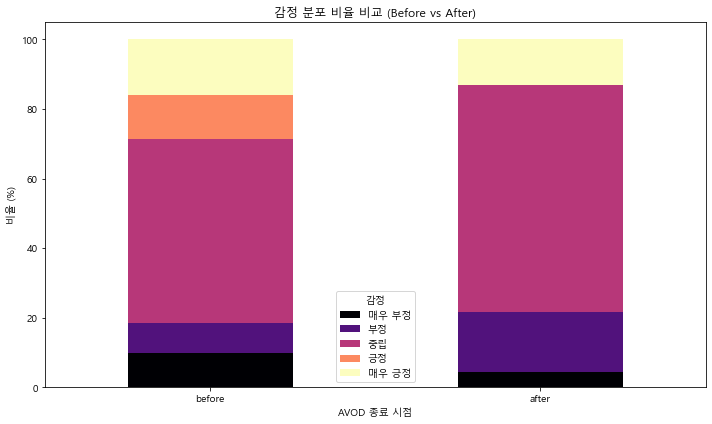

In [22]:
##### 시각화1: 감정 분포 비율 막대그래프 (Before vs After)

import matplotlib.pyplot as plt
import seaborn as sns

# 감정 비율 집계 함수
def get_sentiment_ratio(df, label='sentiment_label'):
    total = len(df)
    return df[label].value_counts(normalize=True).sort_index() * 100  # 비율(%)

# 구간 분리
before_df = for_sentiment_df[for_sentiment_df['avod_end'] == 'before']
after_df = for_sentiment_df[for_sentiment_df['avod_end'] == 'after']

# 비율 계산
before_ratio = get_sentiment_ratio(before_df)
after_ratio = get_sentiment_ratio(after_df)

# 병합
ratio_df = pd.DataFrame({'before': before_ratio, 'after': after_ratio}).fillna(0).T
ratio_df = ratio_df[['매우 부정', '부정', '중립', '긍정', '매우 긍정']]  # 순서 정렬

# 시각화
plt.figure(figsize=(10, 6))
ratio_df.plot(kind='bar', stacked=True, colormap='magma', figsize=(10, 6))
plt.title('감정 분포 비율 비교 (Before vs After)')
plt.ylabel('비율 (%)')
plt.xlabel('AVOD 종료 시점')
plt.xticks(rotation=0)
plt.legend(title='감정')
plt.tight_layout()
plt.show()

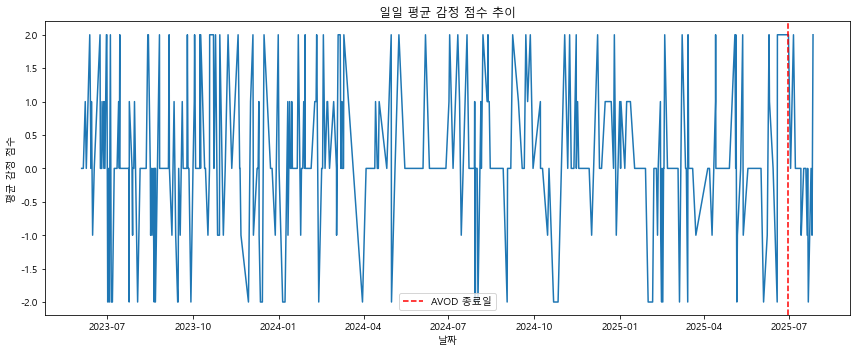

In [23]:
##### 시각화2: 일일 평균 감정 점수 추세선

# 감정 라벨을 수치로 변환 (매우 부정: -2 ~ 매우 긍정: +2)
label_map = {'매우 부정': -2, '부정': -1, '중립': 0, '긍정': 1, '매우 긍정': 2}
for_sentiment_df['sentiment_score'] = for_sentiment_df['sentiment_label'].map(label_map)

# 일일 평균 감정 점수
daily_avg = for_sentiment_df.groupby('date')['sentiment_score'].mean().reset_index()

# 시각화
plt.figure(figsize=(12, 5))
sns.lineplot(data=daily_avg, x='date', y='sentiment_score')
plt.axvline(pd.to_datetime('2025-06-30'), color='red', linestyle='--', label='AVOD 종료일')
plt.title('일일 평균 감정 점수 추이')
plt.ylabel('평균 감정 점수')
plt.xlabel('날짜')
plt.legend()
plt.tight_layout()
plt.show()

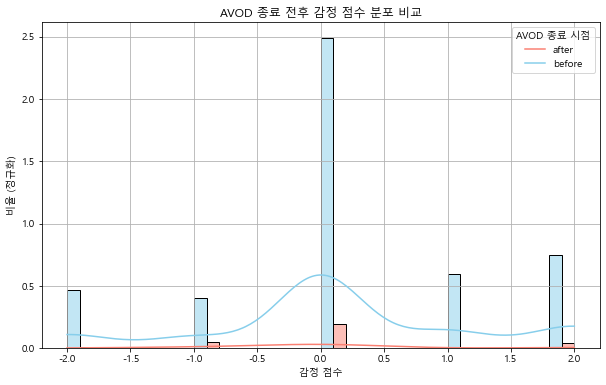

In [24]:
##### 시각화3: 감정 점수 분포 비교 히스토그램

import seaborn as sns

plt.figure(figsize=(10, 6))

# 감정 점수 히스토그램 (정규화)
sns.histplot(
    data=for_sentiment_df,
    x='sentiment_score',
    hue='avod_end',
    hue_order=['before', 'after'],  # 순서 정렬
    kde=True,
    stat="density",
    bins=20,
    palette={'before': 'skyblue', 'after': 'salmon'},
    multiple="dodge"
)

plt.xlabel('감정 점수')
plt.ylabel('비율 (정규화)')
plt.title('AVOD 종료 전후 감정 점수 분포 비교')
plt.legend(title='AVOD 종료 시점', labels=['after', 'before'])
plt.grid(True)
plt.show()

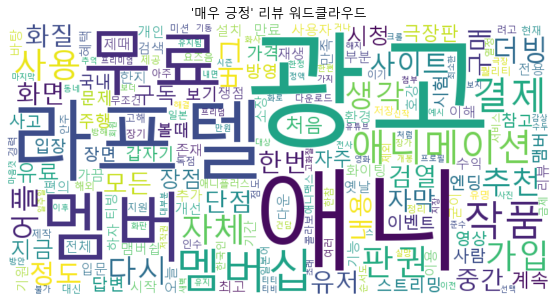

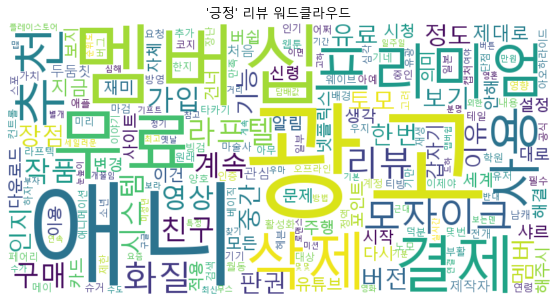

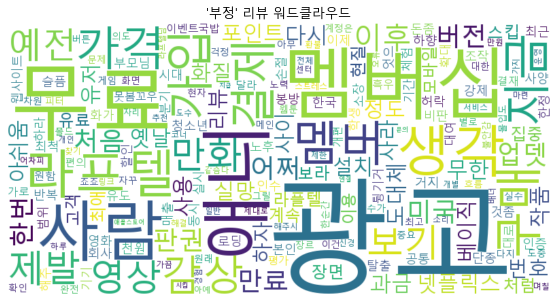

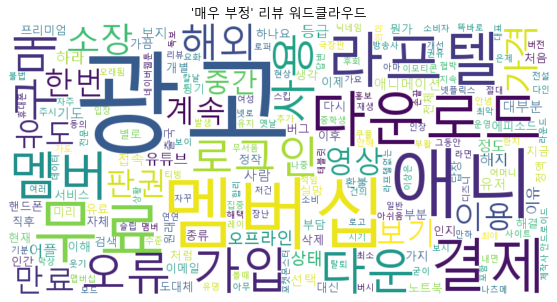

In [25]:
##### 시각화4: 감정 라벨별 워드클라우드 생성

from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

# 워드클라우드 생성 함수
def make_wordcloud(df, label):
    texts = df[df['sentiment_label'] == label]['okt_content']
    tokens = []

    for text in texts:
        tokens.extend(okt.nouns(str(text)))

    word_freq = Counter(tokens)
    wordcloud = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf',  # Windows OS
                          background_color='white',
                          width=800, height=400).generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"'{label}' 리뷰 워드클라우드", fontsize=13)
    plt.axis('off')
    plt.show()
    
# 시각화 (중립 제외)
for label in ['매우 긍정', '긍정', '부정', '매우 부정']:
    make_wordcloud(for_sentiment_df, label)

In [26]:
for_sentiment_df

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,replyContent,appVersion,date,avod_end,okt_content,sentiment_label,sentiment_score
0,251f408a-6062-4d2e-84f7-7254256a9161,하누,첨엔 광고만보면 볼수있었는데 지금은 가입해야해서 볼만한게 없고 미션을께야지 볼수있어...,3,0,3.68.0,None,3.68.0,2025-07-26 16:58:49,after,광고 볼수있었는데 지금 가입 해야 해서 없고 미션 볼수있어서 힘들어요 근데 가보고십...,매우 긍정,2
7,c3ae6f7a-2dee-4001-941b-680571c95405,리오,멤버십을 구매안한 사람은 보지말라는겁니까? 굉장히 짜증나나네요,1,0,3.68.0,None,3.68.0,2025-07-25 15:45:41,after,멤버십 사람 보지말라는 니까 굉장히 짜증나나네요,부정,-1
9,11bb122c-4e4d-4c3e-b204-92286bc32222,YT아야,향기로운 꽃은 늠름하게 핀다 만들어 주세요 무료로 볼수이게 해주세요 ㅠㅠ 인기가 많아요,5,0,3.68.0,"안녕하세요, 라프텔 고객센터입니다. 보고 싶은 작품을 추천해 주셔서 감사합니다. 현...",3.68.0,2025-07-24 14:07:08,after,향기로운 늠름하게 핀다 만들어 주세요 무료 볼수이게 해주세요 인기 많아요,중립,0
20,8dff94f2-146e-41fb-a07b-de1e8c287d29,와사무,멤버십 등급은 왜 있는 건 가요? 해택 아무것도 없고 리뷰 달 때 닉네임 앞에 이모...,2,1,3.67.0,"안녕하세요, 라프텔 고객센터입니다. 오랜 기간 애정을 갖고 이용해 주셔서 감사합니다...",3.67.0,2025-07-21 15:18:24,after,멤버십 등급 가요 해택 아무 없고 리뷰 닉네임 이모티콘 붙는 정도 다인 의미 있나 ...,매우 부정,-2
24,97de6233-4466-4eeb-a84b-d04d60e12e81,성서아,왜 갑자기 광고 무료였던 것들이 다 멤버십으로 됐어요? 그냥 싹 다 유료로 바뀌었는...,3,1,3.65.0,"안녕하세요, 라프텔 고객센터입니다. 광고 보고 무료 보기는 관련 계약 종료로 인해 ...",3.65.0,2025-07-20 22:38:47,after,갑자기 광고 무료 였던 멤버십 됐어요 유료 바뀌었는데 일부 바꾼 예요,중립,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972,03d6ab71-41b4-4ac6-9c49-1012bdcc5a0a,박금옥,좋긴좋은데 무료 애니가 적고 광보가 계속 나오네요..그래도 별5개 가져가시죠!,5,0,3.44.0,None,3.44.0,2023-06-08 22:48:52,before,좋긴 좋은데 무료 애니 적고 광보 계속 나오네요 별개 가져가시죠,중립,0
2981,487edab1-6782-47f5-b8dd-80cd21cd9975,환준이꺼,무료라고 해서 믿고 했지만 역시는 역시네요 무료는 게뿔 처음부터 캐쉬를 사라는데 어...,1,0,None,None,None,2023-06-07 19:57:43,before,무료 라고 해서 믿고 했지만 역시 역시네요 무료 게뿔 처음 캐쉬 사라는데 어디서 무...,긍정,1
2988,0e12303a-3d9a-4f08-9557-f8e9c96e779e,한동석,뭐하는건가요 돈은 빠져나갔는데 멤버십 가입이 안되어있잖아요 빨리 해결해주세요,1,0,None,None,None,2023-06-05 17:57:34,before,하는건 가요 빠져나갔는데 멤버십 가입 안되어있잖아요 빨리 해결 해주세요,중립,0
2991,79a820e4-29c0-46e0-a309-dba12b7ca99c,백현,23분짜리 애니를 광고무료로 보는데 30초짜리 광고 5개봄... 그냥 라프텔 본사 ...,1,1,3.44.0,None,3.44.0,2023-06-05 01:04:03,before,짜리 애니 광고 무료 보는데 짜리 광고 개봄 라프텔 본사 청소 시키던가 짜리 광고 ...,중립,0


In [27]:
# csv 파일로 저장
for_sentiment_df.to_csv('laftel_playstore_reviews_avod.csv', index=False, encoding='utf-8-sig')

# AVOD 종료 이전/이후 리뷰 수 확인
for_sentiment_df['avod_end'].value_counts()

avod_end
before    364
after      23
Name: count, dtype: int64